1: load in the dataset and libraries

In [12]:
import numpy as np
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
import math

image = cv.imread('blok.jpg')


conversion algorithms

841 528


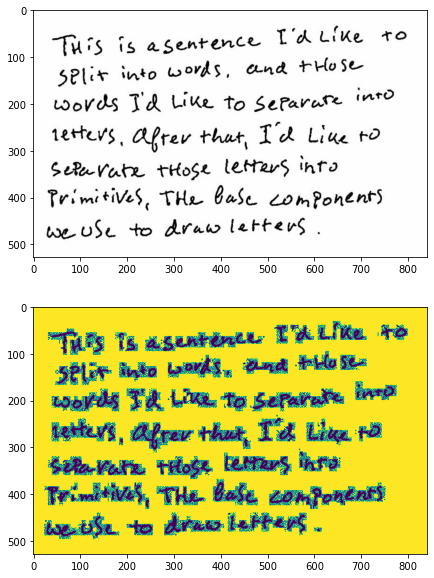

In [13]:
def rgb_to_bin(rgb):
    s = 0
    for i in range(3):
        s += rgb[i]
    #if (s / 3) < 128 #messy images are workable
    if (s / 3) < 254: #anything not white goes through, only for digital paper
        return 0
    else:
        return 1
    
def rgb_to_abs(rgb):
    s = 0
    for i in range(3):
        s += rgb[i]
    #if (s / 3) < 128 #messy images are workable
    if (s / 3) < 254: #anything not white goes through, only for digital paper
        return 0
    else:
        return 255
    
def simplify(img):
    w,h = img.shape[:2]
    #out = [] 
    out = np.zeros(img.shape[:2])
    #print(out)
    for x in range(w):
        #line = []
        for y in range(h):
            #line.append(rgb_to_bin(img[x][y]))
            out[x][y] = rgb_to_bin(img[x][y])
        #out.append(line)
    return out

def absoluteCVGray(cvimg):
    gray = cv.cvtColor(cvimg, cv.COLOR_BGR2GRAY)
    h, w = cvimg.shape[:2]
    print(w, h)
    #print(len(cvimg[0]))
    for y in range(h):
        for x in range(w):
            gray[y][x] = rgb_to_abs(cvimg[y][x])       
    return gray

#gray = simplify(image)
#print(image)
def showImages(imgs):
    fig, axes = plt.subplots(len(imgs), 1, figsize=(10, 10))
    for i in range(len(imgs)):
        axes[i].imshow(imgs[i])
    plt.plot()

cvimage = cv.imread("blok.jpg")
imgray = cv.cvtColor(cvimage, cv.COLOR_BGR2GRAY)
absgray = absoluteCVGray(cvimage)

showImages([image, absgray])

line recognition functions:

In [14]:
# by contours:
def getContours(grayimage):
    indications = np.zeros(grayimage.shape[:2])
    h, w = grayimage.shape[:2]
    ret, thresh = cv.threshold(grayimage, 0, 127, 0)
    contours, hierarchy = cv.findContours(thresh, 1, 2)
    #print(len(contours), contours)
    #cnt = contours[0]
    #M = cv.moments(cnt)
    bounds = []
    for i in range(len(contours)):
        count = len(contours[i])
        #print('contours found: ', count)
        avg = [0, 0] #stores the weighted average
        #stores the bounds
        minx = w
        maxx = 0
        miny = h
        maxy = 0
        for c in range(count):
            point = contours[i][c][0]
            x = point[0]
            y = point[1]
            if x < minx:
                minx = x
            if x > maxx:
                maxx = x
            if y < miny:
                miny = y
            if y > maxy:
                maxy = y
            
            avg[0] += point[0]
            avg[1] += point[1]
            
        avg[0] /= count
        avg[1] /= count
        x = int(round(avg[0]))
        y = int(round(avg[1]))
        bounds.append([x, y, minx, miny, maxx, maxy])
    return bounds 

#a feature is an array of 
features = getContours(imgray)
print(len(features))
#print(features)

3826


100


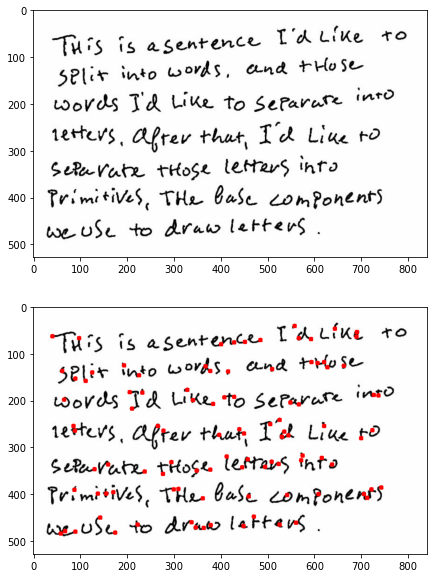

In [17]:
#corner detection:
gray32 = np.float32(imgray)
corners = cv.goodFeaturesToTrack(gray32, 100, 0.01, 10)
corners = np.int0(corners)
print(len(corners))

def sqdist(x1, y1, x2, y2):
    return np.square(x2 - x1) + np.square(y2 - y1)

#shapes that can be added to images for visual coding etc:
class Shape:
    def __init__(self, pos):
        self.pos = pos

class Circle(Shape):
    def __init__(self, pos, radius):
        super().__init__(pos)
        self.radius = radius
    def onImage(self, img):
        h,w = img.shape[:2]
        sx = self.pos[0] - self.radius
        sy = self.pos[1] - self.radius
        if sx < 0:
            sx = 0
        if sy < 0:
            sy = 0
        endx = sx + self.radius * 2
        endy = sy + self.radius * 2
        if (endy > h):
            endy = h
        if (endx > w):
            endx = w
        maxdist = np.square(self.radius)
        for x in range (sx, endx):
            for y in range(sy, endy):
                if sqdist(self.pos[0],self.pos[1], x,y) <= maxdist:
                    img[y][x] = (255, 0 ,0)
        return img
cpy = cv.imread('blok.jpg')
for corner in corners:
    x,y = corner.ravel()
    circle = Circle([x,y], 5)
    circle.onImage(cpy)
showImages([image, cpy])
#     cv.circle(imgray, (x,y), 3, 255, -1)
#cv.imshow('corners', imgray)

In [56]:
#non cv method of getting boxes, tries to stitch colored pixels together
def getBlack(img, treshold = 127):
    out = []
    h, w = img.shape[:2]
    for y in range(h):
        for x in range(w):
            if img[y][x] < treshold:
                out.append([y, x])
    print('percentage black: ',(len(out) / (h*w)) * 100)
    return out

#returns the index of an item in a list
def used(pix, lst):
    for i in range(len(lst)):
        if pix == lst[i]:
            return i
    return -1

def getElement(lst, index):
    out = []
    for i in lst:
        out.append(i[index])
    return out

#returns a new list without the rm index
def rmList(lst, rmindex):
    return lst[:rmindex] + lst[rmindex+1:]

def rmDuplicates(lst):
    original = []
    for i in lst:
        if used(i, original) == -1:
            original.append(i)
    return original
            
def rmAll(lst, rmindeces):
    for i in rmindeces:
        lst = rmList(lst, i)
    return lst

def isNeighbour(a, b):
    if b == a - 1:
        return True
    if b == a + 1:
        return True
    if b == a:
        return True
    return False

def inConv(p1, p2):
    if (isNeighbour(p1[0], p2[0])):
        if (isNeighbour(p1[1], p2[1])):
            if (p1 != p2):
                return True
    return False

def findNeighbours(p1, lst):
    n = []
    for i in range(len(lst)):
        p2 = lst[i]
        if inConv(p1, p2):
            n.append([i, p2])
    return n

class Feature:
    def __init__(self, first):
        self.pixels = []
        #self.pixels.append(first)
        self.toTest = []
        self.toTest.append(first)
    def addPixels(self, lst):
        new = [] #container for new entries
        for p in self.toTest: #go through the list
            #print(used(p, lst))
            if used(p, lst) == -1: #we did not use it yet
                found = findNeighbours(p, lst) #add adjacent pixels to container
                #print('found adjacent: ', found)
                new += found
        new = rmDuplicates(new) #remove doubles
        self.pixels += self.toTest #add what we tested to the definitive pixels array
        self.toTest = new # new test array
        self.toTest = getElement(new, 1)
        return getElement(new, 0) #when no new adjacent pixels are found the algorithm should stop
    
    def getBounds(self):
        minX = 100000
        minY = 100000
        maxX = -1
        maxY = -1
        for p in self.pixels:
            if p[0] < minY:
                minY = p[0]
            if p[0] > maxY:
                maxY = p[0]
            if p[1] < minX:
                minX = p[1]
            if p[1] > maxX:
                maxX = p[1]
        return [minY, minX, maxY, maxX]
    
    def printPixels(self):
        print(self.pixels)

def ShowHighlight(img, pix):
    copy = np.zeros(img.shape[:2])
    
def stitchPixels(img):
    #get all the relevant pixels:
    black = getBlack(img) #all the relevant pixels
    #start = black[0]
    #black = rmList(black, 0)
    #print(findNeighbours(start, black))
    features = []
    features.append(Feature(black[0]))
    #feature = Feature(black[0])
    black = rmList(black, 0)
    #feature = features[len(features) -1]
    #rmList(black, 0)
    #feature = Feature(start)
    #print(feature.pixels)
    maxLoops = len(black)
    loops = 0
    while len(black) > 0 and loops < maxLoops:
        rmindeces = features[len(features) - 1].addPixels(black)
        black = rmAll(black, rmindeces)
        if (len(rmindeces) == 0):
            lastfeature = features[len(features) -1]
            print(lastfeature.pixels)
            print(lastfeature.getBounds())
            features.append(Feature(black[0]))
            black = rmList(black, 0)
        loops += 1
    print(len(features))
    #showFeature
    #take a pixel
    #test it
    #add the new pixels to a test list
    #remove it from the list
    #origin = black[0]
stitchPixels(imgray)
    #for 

percentage black:  7.131661442006269
[[35, 648], [36, 647], [36, 648], [36, 649], [36, 648], [37, 647], [37, 648], [36, 650], [37, 649], [37, 650], [37, 649], [38, 646], [38, 648], [36, 650], [38, 650], [38, 650], [39, 648], [39, 649], [39, 650], [39, 648], [40, 647], [39, 646], [40, 646], [41, 646], [41, 647], [38, 645], [38, 646], [39, 645], [40, 645], [40, 646], [38, 646], [40, 644], [40, 646], [41, 644], [41, 645], [41, 646], [41, 645], [41, 646], [40, 644], [41, 644], [41, 646], [42, 644], [42, 645], [42, 646], [41, 644], [42, 645], [42, 646], [42, 643], [42, 644], [42, 645], [43, 645], [43, 646], [42, 644], [43, 643], [43, 644], [43, 645], [43, 646], [43, 643], [43, 645], [44, 643], [44, 644], [44, 645], [44, 646], [44, 643], [44, 644], [43, 645], [44, 646], [45, 644], [45, 645], [44, 644], [45, 643], [45, 644], [45, 645], [45, 643], [45, 645], [46, 643], [46, 644], [46, 645], [46, 643], [46, 644], [45, 645], [47, 644], [47, 645], [46, 644], [47, 643], [47, 644], [47, 643], [47, 

[[48, 784], [48, 785], [49, 783], [49, 784], [48, 786], [49, 783], [50, 783], [50, 784], [50, 785], [48, 787], [50, 784], [51, 784], [51, 785], [51, 786], [48, 788], [51, 785], [51, 787], [48, 789], [49, 789], [48, 790], [49, 789], [49, 789], [50, 789], [51, 789]]
[48, 783, 51, 790]
[[49, 581], [50, 580], [50, 582], [50, 579], [51, 580], [51, 578], [51, 580], [52, 578], [52, 579], [52, 579], [53, 578], [53, 579], [51, 580], [53, 578], [53, 580], [54, 578], [54, 579], [54, 580], [52, 581], [54, 579], [54, 580], [54, 579], [55, 579], [55, 580], [55, 581], [53, 578], [54, 578], [55, 578], [55, 579], [55, 581], [56, 579], [56, 580], [56, 581], [54, 578], [56, 580], [56, 581], [55, 578], [55, 579], [56, 580], [57, 580], [57, 581], [55, 579], [56, 577], [56, 578], [56, 579], [56, 579], [56, 577], [57, 577], [57, 578], [57, 579], [57, 578], [57, 580], [57, 577], [58, 578], [58, 579], [58, 580], [58, 577], [58, 578], [58, 579], [58, 578], [59, 576], [59, 577], [59, 578], [57, 580], [58, 580], 

[[57, 69], [58, 68], [58, 69], [58, 70], [58, 67], [58, 69], [59, 67], [59, 68], [59, 69], [57, 71], [58, 71], [59, 70], [59, 71], [58, 66], [59, 66], [59, 67], [59, 68], [58, 69], [59, 70], [60, 68], [60, 69], [57, 72], [58, 65], [59, 65], [59, 66], [59, 68], [60, 66], [60, 67], [60, 68], [58, 69], [60, 69], [57, 73], [59, 64], [59, 65], [60, 65], [60, 66], [60, 67], [57, 74], [59, 63], [59, 65], [60, 63], [60, 64], [60, 65], [60, 66], [60, 68], [61, 66], [61, 67], [61, 68], [57, 75], [60, 63], [60, 64], [59, 65], [60, 66], [61, 64], [61, 65], [61, 66], [61, 67], [61, 68], [57, 76], [58, 76], [60, 64], [61, 62], [61, 63], [61, 64], [61, 65], [61, 66], [61, 67], [62, 67], [62, 68], [58, 76], [61, 64], [61, 62], [62, 63], [62, 64], [61, 66], [62, 65], [62, 66], [62, 67], [62, 68], [62, 63], [62, 64], [62, 61], [61, 66], [62, 66], [63, 65], [63, 66], [62, 68], [63, 67], [63, 68], [62, 64], [62, 60], [63, 65], [63, 66], [63, 67], [63, 65], [62, 59], [62, 68], [63, 66], [63, 68], [64, 66],

[[66, 358], [66, 359], [67, 359], [66, 360], [67, 359], [66, 361], [67, 359]]
[66, 358, 67, 361]
[[66, 404]]
[66, 404, 66, 404]
[[66, 437], [67, 436], [67, 437], [67, 438], [67, 435], [67, 437], [68, 435], [68, 436], [68, 437], [68, 438], [68, 435], [68, 436], [67, 437], [68, 438], [69, 436], [69, 437], [68, 436], [69, 434], [69, 435], [69, 436], [69, 437], [69, 436], [69, 434], [70, 434], [70, 435], [70, 436], [70, 437], [70, 435], [70, 437], [70, 434], [71, 435], [71, 436], [71, 437], [71, 434], [71, 435], [71, 436], [71, 435], [72, 434], [72, 435], [70, 437], [71, 437], [72, 436], [72, 437], [72, 434], [72, 436], [73, 434], [73, 435], [73, 436], [71, 437], [73, 437], [73, 434], [73, 435], [72, 436], [73, 437], [74, 435], [74, 436], [74, 437], [73, 435], [74, 434], [74, 435], [74, 436], [74, 437], [74, 438], [74, 434], [74, 436], [75, 435], [74, 438], [75, 437], [75, 438], [75, 435], [75, 437], [75, 439], [74, 436], [76, 436], [76, 440], [75, 437], [76, 441], [77, 439], [77, 440], [7

[[72, 96]]
[72, 96, 72, 96]
[[72, 208]]
[72, 208, 72, 208]
[[72, 252], [72, 253], [72, 254], [72, 255], [72, 256], [72, 257]]
[72, 252, 72, 257]
[[74, 251], [75, 250], [75, 251], [75, 252], [75, 251], [76, 249], [76, 250], [76, 251], [75, 253], [76, 252], [76, 251], [76, 249], [77, 249], [77, 250], [77, 251], [75, 253], [77, 250], [76, 248], [77, 248], [77, 249], [78, 250], [78, 249], [78, 250], [77, 247], [77, 248], [78, 248], [77, 248], [78, 248], [78, 250], [79, 248], [79, 249], [79, 250], [78, 247], [78, 247], [79, 247], [79, 248], [79, 249], [79, 250], [79, 246], [79, 247], [79, 249], [80, 247], [80, 248], [80, 249], [79, 247], [80, 246], [80, 247], [80, 248], [80, 249], [80, 246], [80, 248], [81, 246], [81, 247], [81, 248], [81, 245], [81, 246], [81, 247], [80, 248], [82, 247], [82, 248], [81, 246], [82, 245], [82, 246], [82, 247], [82, 248], [82, 245], [82, 247], [83, 245], [83, 246], [83, 247], [83, 244], [83, 245], [83, 246], [82, 247], [84, 246], [84, 247], [83, 245], [84, 24

[[83, 257], [83, 258], [84, 257], [84, 258], [84, 257], [85, 257], [85, 258], [85, 257]]
[83, 257, 85, 258]
[[83, 361]]
[83, 361, 83, 361]
[[83, 386], [84, 387], [84, 388], [85, 386], [85, 387], [85, 388], [84, 389], [85, 388], [85, 386], [86, 388], [83, 390], [84, 390], [86, 388], [86, 389], [83, 391], [84, 390], [83, 392], [84, 390], [83, 393], [83, 394], [84, 394], [83, 395], [84, 394], [84, 394], [85, 393], [85, 394], [85, 395], [85, 392], [85, 394], [85, 396]]
[83, 386, 86, 396]
[[84, 215], [85, 215]]
[84, 215, 85, 215]
[[84, 254], [85, 255]]
[84, 254, 85, 255]
[[84, 295], [85, 295], [86, 295], [86, 296], [86, 296], [87, 295], [87, 296], [85, 297], [87, 295], [87, 297], [88, 295], [88, 296], [88, 297], [84, 297], [84, 298], [85, 298], [86, 298], [88, 296], [88, 297], [84, 298], [85, 298], [85, 298], [86, 298]]
[84, 295, 88, 298]
[[84, 319]]
[84, 319, 84, 319]
[[84, 321], [85, 322], [84, 323], [85, 323], [86, 322], [86, 323], [84, 324], [85, 323], [84, 325], [85, 323], [84, 326], [

[[108, 660], [108, 661], [109, 662]]
[108, 660, 109, 662]
[[109, 575], [109, 576], [110, 574], [110, 575], [110, 576], [110, 576], [110, 574], [111, 574], [111, 575], [111, 576], [111, 575], [111, 577], [111, 574], [112, 575], [112, 576], [112, 577], [112, 574], [112, 575], [112, 576], [112, 573], [112, 575], [113, 573], [113, 574], [113, 575], [111, 577], [112, 577], [113, 576], [113, 577], [113, 575], [113, 573], [114, 573], [114, 574], [114, 575], [112, 577], [113, 577], [114, 576], [114, 577], [114, 574], [114, 576], [114, 573], [115, 574], [115, 575], [115, 576], [113, 577], [115, 577], [115, 578], [115, 574], [115, 575], [114, 576], [115, 576], [115, 578], [116, 576], [116, 577], [116, 578], [115, 575], [116, 575], [116, 576], [116, 577], [116, 575], [116, 577], [117, 576], [117, 577], [117, 576], [116, 577], [117, 577], [118, 575], [118, 576], [118, 577], [115, 578], [117, 577], [118, 576], [118, 578], [119, 576], [119, 577], [119, 578]]
[109, 573, 119, 578]
[[110, 373], [111, 3

[[117, 645], [118, 645], [118, 646], [118, 646]]
[117, 645, 118, 646]
[[117, 676], [118, 677], [119, 678], [120, 677], [120, 678], [120, 679], [120, 678], [119, 680], [120, 680], [118, 680], [119, 681], [120, 680], [117, 680], [119, 681]]
[117, 676, 120, 681]
[[118, 395], [119, 394], [119, 396]]
[118, 394, 119, 396]
[[118, 575], [118, 576], [119, 574], [119, 576], [119, 577], [120, 575], [120, 577], [118, 578], [120, 578], [119, 579], [120, 578], [121, 579]]
[118, 574, 121, 579]
[[118, 582], [119, 581], [119, 583], [120, 581], [120, 582], [120, 582], [119, 583], [118, 584]]
[118, 581, 120, 584]
[[118, 588]]
[118, 588, 118, 588]
[[118, 635]]
[118, 635, 118, 635]
[[118, 643]]
[118, 643, 118, 643]
[[118, 682], [118, 683], [119, 681]]
[118, 681, 119, 683]
[[119, 396]]
[119, 396, 119, 396]
[[119, 469], [120, 468], [120, 469], [120, 470], [120, 467], [120, 469], [121, 467], [121, 468], [121, 469], [119, 471], [120, 471], [121, 470], [121, 471], [120, 466], [121, 466], [121, 467], [121, 468],

[[124, 695], [125, 694], [125, 695], [125, 696], [125, 693], [125, 695], [126, 693], [125, 692], [126, 692], [126, 693], [125, 691], [126, 691], [126, 692], [125, 690], [126, 690], [126, 691], [125, 689], [126, 689], [126, 690], [127, 690], [125, 688], [126, 688], [126, 689], [127, 689], [127, 690], [125, 687], [126, 687], [126, 688], [127, 688], [127, 689], [127, 690], [125, 686], [126, 686], [126, 687], [127, 687], [127, 688], [127, 689], [125, 685], [126, 685], [126, 686], [127, 686], [127, 687], [127, 688], [126, 684], [126, 685], [127, 685], [127, 686], [127, 687], [126, 683], [126, 685], [127, 683], [127, 684], [127, 685], [127, 686], [127, 688], [126, 682], [127, 682], [127, 683], [127, 684], [126, 685], [127, 686], [128, 684], [128, 685], [125, 681], [126, 681], [127, 681], [127, 682], [127, 684], [128, 682], [128, 683], [128, 684], [126, 685], [128, 685], [125, 680], [126, 680], [126, 681], [128, 683], [128, 684], [128, 685], [125, 679], [126, 679], [126, 680], [127, 680], [12

[[129, 86], [130, 85], [130, 86], [130, 87], [130, 84], [130, 86], [131, 84], [130, 88], [130, 83], [131, 84], [129, 89], [131, 84], [129, 90], [130, 90], [132, 83], [129, 91], [130, 90], [129, 92], [130, 90], [129, 93], [129, 94], [129, 95], [130, 95], [130, 95], [131, 94], [131, 95], [131, 96], [131, 93], [131, 95], [132, 95], [131, 97], [132, 96], [132, 97], [132, 96], [132, 98], [133, 96], [133, 97], [133, 98], [131, 95], [132, 95], [133, 95], [133, 96], [133, 97], [132, 98], [132, 95], [133, 96], [133, 95], [133, 96], [133, 96]]
[129, 83, 133, 98]
[[129, 105], [129, 106], [130, 105], [130, 106], [129, 107], [130, 105], [130, 107], [131, 106], [129, 108], [131, 106], [131, 108], [129, 109], [130, 109], [131, 109], [132, 108], [130, 109], [131, 109], [132, 108]]
[129, 105, 132, 109]
[[129, 232], [129, 233], [129, 234], [130, 234], [129, 235], [130, 234], [130, 234], [131, 233], [131, 234], [131, 235], [131, 232], [131, 234], [132, 232], [132, 233], [132, 234], [132, 235], [132, 232]

[[137, 214], [138, 215], [139, 215], [139, 216], [139, 216], [140, 214], [140, 215], [140, 216], [140, 216], [140, 214], [141, 217], [140, 213], [141, 213], [140, 218], [142, 218], [140, 212], [141, 212], [141, 213], [139, 218], [139, 219], [139, 211], [141, 211], [141, 212], [141, 213], [138, 218], [139, 219], [139, 219]]
[137, 211, 142, 219]
[[137, 395], [138, 395], [138, 396], [138, 396], [139, 394], [139, 395], [139, 396], [137, 397], [139, 396], [139, 394], [140, 394], [140, 395], [137, 398], [138, 398], [140, 395], [140, 397], [137, 399], [138, 398], [138, 398]]
[137, 394, 140, 399]
[[137, 537]]
[137, 537, 137, 537]
[[138, 95], [139, 94], [139, 95], [139, 96], [139, 95], [140, 93], [140, 94], [140, 95], [140, 95], [140, 93], [141, 93], [140, 92], [141, 92], [141, 93], [140, 91], [141, 91], [141, 92], [140, 90], [141, 90], [141, 91], [142, 91], [139, 89], [140, 89], [141, 89], [141, 90], [142, 90], [142, 91], [140, 88], [140, 89], [140, 87], [140, 89], [141, 87], [141, 88], [141, 

[[172, 756], [172, 757], [173, 756], [173, 757], [172, 758], [173, 756], [173, 758], [174, 757], [174, 758], [172, 759], [174, 757], [174, 758], [174, 759], [172, 760], [173, 760], [174, 757], [174, 759], [175, 758], [175, 759], [172, 761], [173, 760], [172, 762], [173, 760], [172, 763], [172, 764], [173, 765], [174, 765], [175, 765], [175, 766], [175, 766], [176, 765], [176, 766], [176, 765], [176, 767], [177, 766], [177, 767], [177, 766], [176, 767], [177, 767], [178, 766], [178, 767], [175, 768], [177, 767]]
[172, 756, 178, 768]
[[173, 756], [174, 757], [175, 758], [174, 759], [175, 759], [173, 760], [175, 759]]
[173, 756, 175, 760]
[[175, 759]]
[175, 759, 175, 759]
[[175, 763]]
[175, 763, 175, 763]
[[176, 232], [176, 233], [177, 231], [177, 232], [177, 233], [177, 233], [177, 231], [178, 233], [178, 233], [178, 234], [178, 234], [179, 232], [179, 233], [179, 234], [179, 234], [179, 232], [180, 232], [180, 233], [180, 234], [180, 233], [180, 232], [181, 233], [181, 234], [181, 232],

[[184, 221], [184, 222], [184, 223], [184, 224], [184, 225]]
[184, 221, 184, 225]
[[184, 257], [185, 257], [185, 258], [185, 258], [186, 258], [184, 259], [186, 258], [185, 260], [185, 261], [185, 262], [184, 263], [185, 263], [185, 263]]
[184, 257, 186, 263]
[[184, 298], [184, 299], [185, 298], [185, 299], [184, 300], [185, 298], [185, 300], [186, 299], [186, 300], [184, 301], [186, 299], [186, 300], [186, 301], [186, 299], [186, 301], [187, 299], [187, 300], [187, 301], [185, 298], [187, 299], [187, 300], [186, 301], [188, 300], [188, 301], [186, 301], [187, 299], [188, 299], [188, 300], [188, 301], [188, 300], [189, 300], [189, 301], [187, 299], [188, 299], [189, 299], [189, 300], [190, 300], [188, 298], [188, 299], [188, 299], [189, 297], [189, 298], [189, 299], [189, 299], [189, 297], [190, 297], [190, 298], [190, 299], [190, 298], [190, 300], [190, 297], [191, 298], [191, 299], [191, 300], [191, 297], [191, 298], [191, 299], [191, 296], [191, 298], [192, 297], [192, 298], [190, 3

[[187, 263], [188, 262], [188, 263], [188, 264], [188, 261], [188, 263], [189, 261], [189, 262], [189, 263], [189, 264], [189, 261], [189, 262], [188, 263], [189, 264], [190, 262], [190, 263], [190, 264], [189, 262], [190, 262], [190, 263], [190, 264], [190, 262], [190, 264], [191, 262], [191, 263], [191, 264], [191, 262], [191, 263], [190, 264], [192, 263], [192, 264], [191, 263], [192, 262], [192, 263], [192, 262], [192, 264], [193, 262], [193, 263], [193, 264], [193, 262], [193, 263], [192, 264], [194, 263], [194, 264], [193, 263], [194, 261], [194, 262], [194, 263], [194, 263], [194, 261], [195, 261], [195, 262], [195, 263], [195, 262], [195, 264], [195, 261], [196, 262], [196, 263], [196, 264], [196, 261], [196, 262], [196, 263], [196, 260], [196, 262], [197, 260], [197, 261], [197, 262], [195, 264], [196, 264], [197, 263], [197, 262], [197, 260], [198, 260], [198, 261], [198, 262], [196, 264], [198, 263], [198, 261], [198, 263], [198, 259], [198, 260], [199, 261], [199, 262], [19

[[188, 649], [188, 650], [189, 648], [189, 649], [189, 650], [189, 650], [189, 648], [190, 649], [190, 650], [190, 649], [190, 650], [189, 647], [190, 650], [191, 651], [192, 650]]
[188, 647, 192, 651]
[[188, 704], [188, 705], [189, 706]]
[188, 704, 189, 706]
[[188, 713]]
[188, 713, 188, 713]
[[189, 539]]
[189, 539, 189, 539]
[[189, 545]]
[189, 545, 189, 545]
[[189, 644]]
[189, 644, 189, 644]
[[189, 758], [190, 757], [190, 758], [190, 759], [190, 758], [191, 756], [191, 757], [191, 758], [190, 760], [191, 759], [191, 760], [191, 758], [191, 756], [192, 756], [192, 757], [190, 760], [191, 760], [192, 757], [191, 755], [192, 755], [192, 756], [189, 761], [191, 760], [192, 754], [192, 755], [189, 762], [191, 753], [192, 753], [192, 755], [189, 763], [190, 752], [191, 752], [192, 753], [191, 752], [192, 753]]
[189, 752, 192, 763]
[[190, 220]]
[190, 220, 190, 220]
[[190, 738]]
[190, 738, 190, 738]
[[191, 127], [191, 128], [192, 127], [191, 129], [192, 127], [191, 130]]
[191, 127, 192, 130]


[[194, 66], [194, 67], [194, 68], [194, 69], [195, 69], [195, 69], [196, 69], [196, 70], [196, 70], [197, 68], [197, 69], [197, 70], [197, 70], [197, 68], [198, 71], [196, 67], [197, 67], [198, 67], [198, 72], [199, 72], [197, 66], [197, 67], [199, 72], [197, 65], [197, 67], [198, 65], [198, 67], [200, 73], [198, 65], [199, 74], [200, 74], [201, 74], [199, 66], [198, 75], [199, 75], [200, 74], [198, 67], [199, 67], [200, 66], [199, 75], [197, 67], [199, 67], [200, 74], [200, 76], [201, 74], [201, 75], [201, 75], [202, 74], [202, 75], [200, 76], [202, 74], [202, 76], [203, 74], [203, 75], [203, 76], [203, 75], [203, 76], [202, 74], [203, 74], [203, 76], [204, 75], [204, 76], [203, 74], [204, 75], [204, 76], [204, 77], [204, 75], [204, 77], [205, 75], [205, 76], [205, 77], [205, 75], [205, 76], [204, 77], [205, 78], [206, 76], [206, 77], [206, 78], [205, 76], [206, 75], [206, 76], [206, 77], [206, 78], [206, 75], [206, 77], [207, 75], [207, 76], [207, 77], [207, 75], [207, 76], [206, 77]

[[195, 553], [195, 554], [196, 553], [196, 554], [195, 555], [196, 553], [196, 555], [197, 553], [197, 554], [197, 555], [195, 556], [197, 554], [197, 555], [197, 554], [198, 554], [198, 555], [198, 556], [196, 553], [197, 553], [198, 553], [198, 554], [198, 556], [199, 555], [197, 552], [197, 553], [199, 555], [197, 551], [197, 553], [198, 551], [198, 552], [198, 553], [198, 551], [198, 552], [197, 553], [198, 554], [198, 552], [199, 555]]
[195, 551, 199, 556]
[[196, 72], [196, 73]]
[196, 72, 196, 73]
[[196, 251], [197, 252]]
[196, 251, 197, 252]
[[196, 529]]
[196, 529, 196, 529]
[[196, 533], [197, 532], [197, 534]]
[196, 532, 197, 534]
[[196, 538], [197, 537], [197, 538], [197, 539], [197, 536], [197, 538], [197, 540], [198, 535], [197, 534]]
[196, 534, 198, 540]
[[196, 542]]
[196, 542, 196, 542]
[[196, 603]]
[196, 603, 196, 603]
[[197, 51]]
[197, 51, 197, 51]
[[197, 256]]
[197, 256, 197, 256]
[[197, 323]]
[197, 323, 197, 323]
[[197, 443]]
[197, 443, 197, 443]
[[197, 446], [197, 447]

[[202, 611], [203, 611], [203, 612], [203, 612], [204, 610], [204, 611], [204, 612], [204, 612], [204, 610], [205, 610], [205, 611], [205, 612], [205, 611], [205, 613], [203, 609], [204, 609], [205, 610], [206, 611], [206, 612], [206, 613], [205, 610], [206, 610], [206, 611], [206, 612], [204, 608], [204, 609], [204, 609], [206, 610], [206, 612], [207, 611], [207, 612], [204, 607], [205, 607], [205, 613], [207, 611], [207, 612], [207, 613], [204, 606], [205, 606], [205, 607], [206, 614], [207, 611], [207, 613], [203, 605], [205, 605], [205, 606], [206, 606], [204, 604], [205, 605], [206, 605], [206, 606], [205, 603], [205, 604], [205, 605], [205, 602], [205, 604], [206, 602], [206, 603], [206, 604], [206, 605], [206, 606], [205, 601], [206, 601], [206, 602], [206, 603], [205, 604], [206, 605], [207, 603], [207, 604], [207, 605], [206, 600], [206, 601], [206, 603], [207, 601], [207, 602], [207, 603], [205, 604], [207, 604], [207, 605], [206, 599], [206, 601], [207, 599], [207, 600], [20

[[240, 523], [241, 523], [241, 524], [241, 524], [242, 522], [242, 523], [242, 524], [240, 525], [242, 524], [242, 522], [243, 522], [243, 523], [243, 524], [243, 523], [243, 524], [242, 522], [243, 522], [243, 524], [244, 522], [241, 521], [242, 521], [243, 521], [243, 522], [242, 520], [242, 521], [242, 521], [243, 521], [243, 521], [244, 522], [245, 521], [245, 520], [246, 520], [245, 519], [246, 519], [246, 520], [245, 518], [246, 518], [246, 519], [247, 519], [247, 520], [246, 518], [247, 518], [247, 519], [247, 520], [247, 517], [247, 518], [247, 520], [248, 518], [247, 518], [248, 517], [248, 518], [248, 517], [249, 517], [249, 517]]
[240, 517, 249, 525]
[[241, 527]]
[241, 527, 241, 527]
[[245, 503], [246, 502], [246, 503], [246, 504], [246, 501], [246, 503], [247, 501], [247, 502], [247, 503], [245, 505], [246, 505], [247, 504], [247, 505], [246, 500], [247, 500], [247, 501], [247, 502], [246, 503], [247, 504], [248, 502], [248, 504], [245, 506], [247, 506], [248, 505], [248, 5

[[253, 104], [254, 104], [254, 105], [254, 105], [255, 103], [255, 104], [255, 105], [255, 105], [255, 103], [256, 103], [256, 104], [256, 105], [256, 104], [256, 106], [255, 102], [256, 102], [256, 103], [257, 104], [257, 105], [257, 106], [257, 103], [257, 104], [257, 105], [256, 102], [257, 102], [257, 102], [258, 102], [258, 103], [258, 104], [258, 105], [256, 106], [257, 106], [258, 106], [258, 102], [258, 104], [259, 102], [259, 103], [259, 104], [257, 106], [258, 106], [259, 105], [259, 106], [259, 101], [259, 102], [259, 103], [258, 104], [259, 105], [260, 103], [260, 104], [260, 105], [259, 107], [260, 106], [259, 100], [259, 102], [260, 100], [260, 101], [260, 102], [260, 103], [260, 104], [259, 105], [258, 108], [260, 106], [260, 99], [260, 100], [260, 101], [259, 102], [260, 103], [261, 101], [261, 102], [261, 103], [260, 105], [261, 104], [261, 105], [257, 108], [260, 98], [260, 100], [261, 98], [261, 99], [261, 100], [261, 101], [261, 102], [260, 103], [261, 104], [261, 1

[[261, 702], [262, 701], [262, 702], [262, 703], [262, 702], [263, 700], [263, 701], [263, 702], [263, 703], [263, 702], [263, 700], [264, 700], [264, 701], [264, 702], [264, 701], [264, 699], [264, 700], [265, 701], [265, 702], [264, 700], [265, 700], [265, 701], [265, 702], [265, 699], [265, 699], [266, 699], [266, 700], [266, 701], [265, 702], [266, 702], [266, 698], [266, 699], [266, 701], [267, 699], [267, 700], [267, 701], [265, 702], [266, 703], [267, 702], [267, 703], [266, 697], [266, 699], [267, 697], [267, 698], [267, 699], [267, 700], [267, 701], [266, 703], [267, 703], [268, 701], [268, 702], [268, 703], [267, 697], [267, 698], [266, 699], [267, 700], [268, 698], [268, 699], [268, 700], [268, 701], [268, 702], [267, 703], [267, 698], [268, 697], [268, 698], [268, 699], [268, 700], [268, 701], [267, 703], [268, 703], [269, 701], [269, 702], [269, 703], [268, 697], [268, 699], [269, 698], [269, 699], [268, 701], [269, 700], [269, 701], [267, 703], [269, 702], [269, 703], [26

[[264, 548], [265, 547], [265, 549], [265, 546], [266, 546], [266, 547], [266, 548], [266, 545], [266, 546], [266, 548], [267, 546], [267, 547], [267, 548], [266, 546], [267, 545], [267, 546], [265, 549], [267, 547], [267, 548], [267, 545], [267, 547], [268, 545], [268, 546], [268, 547], [268, 548], [268, 544], [268, 545], [268, 546], [267, 547], [268, 548], [269, 546], [269, 547], [268, 545], [269, 544], [269, 545], [269, 546], [269, 547], [268, 548], [269, 544], [269, 546], [270, 544], [270, 545], [270, 546], [268, 548], [270, 547], [270, 544], [270, 545], [269, 546], [270, 547], [271, 547], [270, 545], [271, 543], [271, 547], [272, 546], [272, 547], [272, 548], [272, 545], [272, 547], [273, 545], [273, 546], [273, 547], [273, 548], [272, 544], [273, 544], [273, 545], [273, 546], [272, 547], [273, 548], [274, 546], [274, 547], [274, 548], [271, 543], [273, 543], [273, 544], [273, 546], [274, 544], [274, 546], [272, 547], [274, 547], [274, 548], [274, 549], [272, 542], [273, 543], [27

[[265, 148], [265, 149], [266, 148], [266, 149], [265, 150], [266, 148], [266, 150], [267, 148], [267, 149], [267, 150], [265, 151], [267, 149], [267, 150], [267, 149], [268, 149], [266, 148], [267, 148], [268, 148], [268, 149], [267, 148], [268, 148], [268, 149], [268, 149], [269, 147], [269, 148], [269, 149], [269, 149], [269, 147], [270, 147], [270, 148], [270, 149], [270, 148], [270, 146], [270, 147], [271, 148], [270, 147], [271, 147], [271, 148], [271, 145], [271, 146], [271, 147], [272, 147], [272, 148], [271, 145], [272, 145], [272, 146], [272, 146], [273, 146], [273, 147], [271, 144], [272, 144], [272, 145], [273, 145], [273, 146], [274, 146], [274, 147], [270, 143], [271, 143], [272, 143], [272, 144], [273, 144], [272, 144], [273, 144], [273, 146], [274, 144], [274, 145], [274, 146], [269, 142], [270, 142], [271, 142], [271, 143], [271, 143], [272, 143], [273, 143], [273, 144], [274, 145], [274, 146], [268, 141], [268, 142], [269, 141], [270, 141], [270, 142], [270, 142], [27

[[274, 116], [275, 117], [275, 118], [276, 117], [276, 118], [275, 119], [276, 117], [276, 119], [274, 120], [275, 120], [275, 120], [276, 121], [275, 122], [277, 121], [277, 122], [276, 123], [277, 121], [277, 123], [276, 124], [278, 124], [277, 125], [278, 124]]
[274, 116, 278, 125]
[[274, 420]]
[274, 420, 274, 420]
[[274, 495]]
[274, 495, 274, 495]
[[274, 547]]
[274, 547, 274, 547]
[[274, 615]]
[274, 615, 274, 615]
[[274, 661]]
[274, 661, 274, 661]
[[274, 663]]
[274, 663, 274, 663]
[[275, 237]]
[275, 237, 275, 237]
[[275, 319], [276, 318]]
[275, 318, 276, 319]
[[275, 329], [275, 330], [276, 329], [276, 329]]
[275, 329, 276, 330]
[[275, 422], [276, 421], [276, 422], [276, 420], [276, 422], [277, 420], [277, 421], [277, 422], [277, 419], [277, 420], [277, 421], [276, 422], [278, 421], [278, 422], [278, 423], [277, 420], [278, 419], [278, 420], [278, 421], [278, 422], [278, 419], [278, 421], [279, 419], [279, 420], [279, 421], [278, 423], [279, 422], [279, 423], [279, 418], [279, 419],

[[285, 248], [286, 248], [286, 249], [286, 249], [287, 247], [287, 248], [287, 249], [287, 249], [287, 247], [287, 246]]
[285, 246, 287, 249]
[[285, 320], [286, 320]]
[285, 320, 286, 320]
[[286, 190]]
[286, 190, 286, 190]
[[286, 251], [286, 252]]
[286, 251, 286, 252]
[[286, 261], [287, 260], [287, 261], [287, 262], [287, 261], [288, 260], [288, 261], [287, 263], [288, 262], [288, 263], [288, 260], [288, 262], [289, 260], [289, 261], [289, 262], [287, 263], [289, 263], [289, 264], [289, 260], [289, 261], [288, 262], [289, 263], [290, 262], [290, 263], [290, 264], [289, 261], [290, 262], [290, 263], [290, 264], [290, 262], [290, 264], [291, 264]]
[286, 260, 291, 264]
[[286, 302]]
[286, 302, 286, 302]
[[286, 487], [286, 488], [287, 487], [287, 487]]
[286, 487, 287, 488]
[[286, 505]]
[286, 505, 286, 505]
[[287, 254], [288, 254], [288, 255], [288, 255], [289, 255], [287, 256], [289, 255]]
[287, 254, 289, 256]
[[288, 278], [289, 279]]
[288, 278, 289, 279]
[[289, 189]]
[289, 189, 289, 189]
[[

[[325, 48], [325, 49], [326, 47], [326, 48], [326, 49], [326, 49], [326, 47], [327, 47], [327, 48], [327, 49], [327, 48], [327, 50], [326, 46], [327, 46], [327, 47], [328, 48], [328, 49], [328, 50], [328, 47], [328, 48], [328, 49], [327, 45], [327, 46], [328, 46], [327, 46], [328, 46], [328, 48], [329, 46], [329, 47], [329, 48], [329, 49], [329, 50], [328, 44], [328, 45], [328, 46], [329, 47], [329, 48], [329, 50], [330, 48], [330, 49], [330, 50], [328, 44], [329, 44], [329, 45], [329, 46], [329, 45], [329, 47], [330, 47], [330, 48], [330, 49], [330, 50], [330, 51], [329, 43], [329, 44], [330, 45], [330, 46], [329, 44], [330, 44], [330, 45], [330, 46], [330, 47], [330, 48], [331, 48], [331, 49], [331, 50], [330, 42], [330, 43], [330, 44], [331, 44], [331, 45], [331, 46], [331, 47], [330, 48], [331, 48], [330, 42], [331, 42], [331, 43], [331, 43], [331, 44], [332, 44], [332, 45], [332, 47], [330, 48], [331, 48], [332, 48], [331, 42], [331, 42], [332, 42], [332, 43], [332, 44], [332, 45]

[[327, 432], [328, 433], [327, 434], [329, 432], [329, 434], [329, 435], [328, 436], [327, 437], [328, 437], [329, 437], [328, 437], [329, 437], [329, 438], [329, 438], [330, 437], [330, 438], [330, 437], [331, 437], [331, 438], [331, 436], [331, 437], [332, 437], [331, 437], [332, 436], [332, 437], [332, 436], [333, 436], [333, 437], [333, 436], [334, 436], [334, 437], [334, 435], [334, 436], [334, 436], [335, 435], [335, 435], [336, 434], [336, 435], [336, 433], [336, 435], [337, 433], [337, 434], [335, 432], [336, 432], [337, 432], [337, 433], [337, 434], [336, 431], [336, 432], [337, 433], [338, 433], [336, 430], [336, 432], [337, 430], [337, 431], [337, 432], [336, 429], [337, 430], [337, 431], [336, 432], [337, 433], [338, 431], [338, 432], [338, 433], [337, 430], [336, 432], [338, 430], [338, 431], [338, 432], [338, 429], [338, 430], [338, 431], [337, 433], [338, 433], [339, 431], [339, 432], [338, 428], [338, 430], [339, 430], [339, 431], [339, 432], [338, 433], [339, 427], [33

[[332, 154], [332, 155], [333, 153], [333, 154], [333, 155], [332, 156], [333, 155], [333, 153], [334, 153], [334, 154], [334, 155], [332, 157], [334, 154], [334, 155], [332, 158], [334, 154], [335, 154], [335, 155], [332, 159], [333, 159], [332, 160], [333, 159], [332, 161], [333, 159]]
[332, 153, 335, 161]
[[332, 428]]
[332, 428, 332, 428]
[[332, 499]]
[332, 499, 332, 499]
[[332, 511]]
[332, 511, 332, 511]
[[332, 521], [332, 522], [333, 521], [333, 522], [332, 523], [333, 521], [333, 523], [334, 521], [334, 522], [334, 523], [332, 524], [334, 522], [334, 523], [333, 525], [334, 522], [335, 522], [335, 523], [335, 524], [335, 523], [335, 525], [336, 523], [336, 524], [336, 525], [334, 522], [335, 522], [336, 523], [336, 524], [335, 525], [333, 521], [334, 521], [335, 521], [335, 522], [336, 524], [334, 520], [334, 521], [334, 519], [334, 521], [335, 519], [335, 520], [335, 521], [334, 518], [335, 518], [335, 519], [335, 520], [334, 521], [335, 522], [336, 520], [336, 521], [335, 517],

[[336, 370], [337, 369], [337, 370], [337, 368], [337, 370], [338, 368], [338, 369], [338, 370], [338, 368], [338, 369], [337, 370], [338, 369]]
[336, 368, 338, 370]
[[336, 427]]
[336, 427, 336, 427]
[[336, 507], [336, 508]]
[336, 507, 336, 508]
[[336, 589]]
[336, 589, 336, 589]
[[337, 91]]
[337, 91, 337, 91]
[[337, 111]]
[337, 111, 337, 111]
[[337, 202], [337, 203]]
[337, 202, 337, 203]
[[337, 207], [338, 207], [338, 208], [338, 208]]
[337, 207, 338, 208]
[[337, 222]]
[337, 222, 337, 222]
[[337, 281], [338, 281], [338, 282], [338, 282]]
[337, 281, 338, 282]
[[337, 287]]
[337, 287, 337, 287]
[[337, 539]]
[337, 539, 337, 539]
[[337, 542], [338, 543], [339, 543]]
[337, 542, 339, 543]
[[337, 587]]
[337, 587, 337, 587]
[[337, 634]]
[337, 634, 337, 634]
[[338, 97], [339, 96], [340, 95], [340, 96], [340, 97], [340, 94], [340, 96], [341, 94], [341, 95], [341, 96], [340, 98], [340, 93], [341, 93], [341, 94], [341, 95], [340, 96], [339, 99], [340, 92], [341, 92], [341, 93], [341, 95], [340, 91]

[[344, 332], [344, 333], [345, 332], [345, 333], [345, 332], [345, 334], [346, 332], [346, 333], [346, 334], [346, 332], [346, 333], [345, 334], [346, 335], [347, 333], [347, 334], [347, 335], [346, 333], [347, 332], [347, 333], [344, 335], [347, 334], [347, 335], [347, 332], [347, 334], [348, 332], [348, 333], [348, 334], [348, 335], [348, 332], [348, 333], [347, 334], [348, 335], [349, 333], [349, 334], [348, 333], [349, 332], [349, 333], [349, 334], [349, 332], [349, 334], [350, 333], [350, 334], [350, 331], [350, 333], [351, 330], [351, 331], [351, 332], [351, 329], [351, 331], [352, 329], [352, 330], [352, 331], [350, 333], [351, 333], [352, 332], [352, 328], [352, 329], [352, 330], [351, 331], [352, 332], [353, 330], [353, 331], [349, 334], [352, 327], [352, 329], [353, 327], [353, 328], [353, 329], [353, 330], [353, 331], [352, 332], [352, 326], [353, 326], [353, 327], [353, 328], [352, 329], [353, 330], [354, 328], [354, 329], [354, 330], [352, 325], [353, 325], [353, 326], [35

[[350, 374], [350, 375], [351, 374], [351, 374]]
[350, 374, 351, 375]
[[350, 539], [351, 538], [351, 539], [351, 540], [351, 537], [351, 539]]
[350, 537, 351, 540]
[[351, 50]]
[351, 50, 351, 50]
[[351, 74]]
[351, 74, 351, 74]
[[351, 120]]
[351, 120, 351, 120]
[[351, 125]]
[351, 125, 351, 125]
[[351, 177], [352, 176], [352, 177], [352, 178], [352, 175], [352, 177], [352, 179], [353, 178], [353, 179], [353, 174], [353, 178], [353, 179], [353, 180], [353, 178], [353, 180], [354, 180], [352, 177]]
[351, 174, 354, 180]
[[351, 213], [352, 214], [351, 215], [353, 213], [353, 214], [353, 215], [352, 216], [353, 213], [353, 215], [354, 213], [354, 214], [353, 217], [354, 214]]
[351, 213, 354, 217]
[[351, 219], [352, 219]]
[351, 219, 352, 219]
[[351, 539]]
[351, 539, 351, 539]
[[352, 237], [352, 238], [353, 236], [353, 237], [353, 238], [353, 238], [353, 236], [354, 236], [354, 237], [354, 237], [353, 235], [354, 235], [354, 236], [353, 234], [354, 234], [354, 235], [355, 235], [353, 233], [354,

[[382, 225], [382, 226], [383, 225], [383, 226], [382, 227], [383, 225], [383, 227], [384, 225], [384, 226], [384, 227], [382, 228], [384, 226], [384, 227], [384, 226], [385, 226], [385, 227], [385, 228], [383, 225], [384, 225], [385, 225], [385, 226], [385, 228], [386, 226], [384, 224], [384, 225], [384, 223], [384, 225], [385, 223], [385, 224], [385, 225], [385, 222], [385, 223], [385, 224], [384, 225], [385, 226], [386, 224], [386, 225], [386, 226], [385, 223], [386, 221], [386, 222], [386, 223], [386, 224], [386, 225], [385, 226], [386, 223], [386, 221], [387, 221], [387, 222], [387, 223], [386, 225], [387, 224], [387, 222], [387, 224], [387, 220], [387, 221], [388, 222], [388, 223], [387, 221], [388, 221], [388, 222], [388, 223], [386, 225], [388, 220], [388, 220], [388, 221], [389, 221], [389, 222], [389, 223], [385, 226], [388, 221], [389, 219], [389, 220], [389, 221], [389, 222], [390, 222], [389, 221], [389, 219], [390, 219], [390, 220], [390, 221], [390, 222], [390, 220], [39

[[387, 198], [388, 197], [388, 198], [388, 199], [388, 198], [389, 198], [388, 200], [389, 199], [389, 200], [389, 198], [388, 200], [389, 200], [390, 198], [390, 199], [390, 200], [390, 197], [390, 198], [390, 199], [389, 200], [389, 201], [390, 198], [391, 197], [391, 198], [390, 200], [391, 199], [391, 200], [389, 201], [391, 197], [391, 199], [392, 197], [392, 198], [392, 199], [390, 200], [392, 200], [392, 196], [392, 197], [392, 198], [391, 199], [392, 200], [393, 198], [393, 199], [392, 195], [392, 197], [393, 195], [393, 196], [393, 197], [393, 198], [393, 199], [392, 200], [393, 194], [393, 195], [393, 196], [392, 197], [393, 198], [394, 196], [394, 197], [394, 198], [393, 195], [394, 193], [394, 194], [394, 195], [394, 196], [394, 197], [393, 198], [394, 195], [394, 193], [395, 193], [395, 194], [395, 195], [394, 197], [395, 196], [395, 197], [395, 194], [395, 196], [395, 193], [396, 194], [396, 195], [396, 196], [394, 197], [396, 193], [396, 194], [396, 195], [396, 192], [39

[[390, 49], [391, 48], [391, 49], [391, 50], [391, 47], [391, 49], [392, 47], [392, 48], [392, 49], [390, 51], [391, 51], [392, 50], [392, 51], [392, 46], [392, 47], [392, 48], [391, 49], [392, 50], [393, 48], [393, 49], [393, 50], [392, 45], [392, 47], [393, 45], [393, 46], [393, 47], [393, 48], [393, 49], [392, 50], [392, 44], [393, 44], [393, 45], [393, 46], [392, 47], [393, 48], [394, 46], [394, 47], [394, 48], [393, 50], [394, 49], [393, 43], [393, 44], [393, 46], [394, 44], [394, 45], [394, 46], [392, 47], [394, 47], [394, 48], [394, 49], [392, 42], [393, 42], [393, 44], [394, 42], [394, 43], [394, 44], [394, 45], [394, 46], [394, 48], [395, 46], [393, 50], [391, 41], [391, 42], [392, 41], [393, 42], [394, 43], [394, 44], [394, 46], [395, 44], [395, 45], [395, 46], [391, 40], [391, 42], [392, 40], [392, 41], [391, 39], [392, 39], [392, 40], [392, 41], [392, 38], [392, 39], [392, 41], [392, 37], [392, 39], [391, 42], [393, 42]]
[390, 37, 395, 51]
[[390, 87], [390, 88], [390, 89]]


[[397, 600], [397, 601], [398, 599], [398, 601], [397, 602], [398, 602], [399, 602], [398, 602], [399, 602], [400, 601], [400, 602], [400, 603], [400, 602], [401, 602], [399, 604], [400, 604], [401, 603], [401, 604], [401, 602], [400, 604], [401, 604], [402, 603], [402, 604], [402, 603], [401, 604], [401, 605], [402, 604], [403, 603], [403, 604], [401, 605], [402, 605], [402, 605], [403, 603], [403, 605], [404, 603], [404, 604], [404, 605], [400, 606], [404, 604], [404, 605], [399, 606], [399, 607], [403, 603], [404, 603], [404, 605], [405, 603], [405, 604], [405, 605], [399, 607], [404, 602], [404, 603], [405, 604], [405, 605], [404, 603], [405, 601], [405, 602], [405, 603], [405, 603], [405, 601], [406, 601], [406, 602], [406, 603], [406, 602], [406, 604], [406, 601], [407, 602], [407, 603], [407, 604], [407, 601], [407, 602], [407, 603], [407, 602], [408, 601], [408, 602], [406, 604], [407, 604], [408, 603], [408, 604], [408, 601], [408, 603], [409, 601], [409, 602], [409, 603], [40

[[399, 568], [400, 568], [400, 569], [400, 569]]
[399, 568, 400, 569]
[[399, 708], [399, 709], [400, 707], [400, 708], [400, 709], [400, 709], [400, 707]]
[399, 707, 400, 709]
[[400, 66], [401, 66]]
[400, 66, 401, 66]
[[400, 68], [401, 68]]
[400, 68, 401, 68]
[[400, 102], [400, 103], [401, 102], [401, 103], [401, 102], [401, 104], [402, 104]]
[400, 102, 402, 104]
[[400, 441], [401, 441], [401, 442], [401, 442]]
[400, 441, 401, 442]
[[400, 444], [401, 444], [402, 445], [403, 444], [403, 446]]
[400, 444, 403, 446]
[[400, 517]]
[400, 517, 400, 517]
[[400, 521]]
[400, 521, 400, 521]
[[401, 73]]
[401, 73, 401, 73]
[[401, 104], [402, 104]]
[401, 104, 402, 104]
[[401, 425], [401, 426]]
[401, 425, 401, 426]
[[401, 629], [402, 628], [402, 629], [402, 629], [403, 627], [403, 628], [403, 629], [403, 629], [403, 627], [404, 627], [404, 628], [404, 629], [404, 628], [404, 630], [403, 626], [404, 626], [404, 627], [405, 627], [403, 625], [404, 625], [404, 626], [405, 626], [405, 626], [406, 626], [4

[[405, 86], [406, 85], [406, 86], [406, 84], [406, 86], [407, 84], [407, 85], [407, 86], [406, 83], [407, 83], [407, 84], [407, 85], [406, 86], [408, 85], [408, 86], [408, 87], [407, 83], [407, 85], [408, 83], [408, 84], [408, 85], [408, 83], [408, 84], [407, 85], [408, 86], [409, 84], [409, 85], [409, 86], [408, 84], [409, 83], [409, 84], [406, 86], [409, 85], [409, 86], [409, 87], [409, 83], [409, 85], [410, 83], [410, 84], [410, 85], [409, 87], [410, 86], [410, 87], [410, 82], [410, 83], [410, 84], [409, 85], [410, 86], [411, 84], [411, 85], [411, 86], [410, 88], [411, 87], [411, 88], [410, 83], [411, 82], [411, 83], [411, 84], [411, 85], [410, 86], [411, 87], [411, 88], [411, 82], [411, 84], [412, 82], [412, 83], [412, 84], [410, 86], [411, 86], [412, 85], [412, 86], [411, 88], [412, 87], [412, 82], [412, 83], [411, 84], [412, 85], [413, 83], [413, 84], [413, 85], [412, 87], [413, 86], [412, 83], [413, 83], [413, 84], [413, 85], [413, 86], [413, 83], [413, 85], [414, 84], [414, 85]

[[410, 323], [410, 324], [411, 322], [411, 323], [411, 324], [410, 325], [411, 324], [411, 322]]
[410, 322, 411, 325]
[[410, 356]]
[410, 356, 410, 356]
[[410, 416], [411, 416], [411, 417], [411, 417], [412, 416], [412, 416]]
[410, 416, 412, 417]
[[411, 322]]
[411, 322, 411, 322]
[[411, 399], [412, 399]]
[411, 399, 412, 399]
[[412, 356], [412, 357], [413, 355], [413, 356], [413, 357], [412, 358], [413, 357], [413, 355], [412, 359]]
[412, 355, 413, 359]
[[412, 630]]
[412, 630, 412, 630]
[[412, 657]]
[412, 657, 412, 657]
[[412, 659], [413, 659]]
[412, 659, 413, 659]
[[412, 709]]
[412, 709, 412, 709]
[[413, 340], [413, 341], [414, 339], [414, 340], [414, 341], [414, 341], [414, 339], [415, 342], [414, 338], [414, 343], [415, 343], [414, 337], [415, 337], [413, 344], [415, 343], [414, 336], [415, 336], [415, 337], [416, 344], [416, 345], [416, 346], [415, 347], [416, 347], [414, 346], [414, 347], [414, 348], [416, 347], [414, 347], [413, 348], [414, 349], [415, 349], [414, 349], [413, 350],

[[451, 470]]
[451, 470, 451, 470]
[[452, 299]]
[452, 299, 452, 299]
[[452, 301]]
[452, 301, 452, 301]
[[453, 471]]
[453, 471, 453, 471]
[[453, 527]]
[453, 527, 453, 527]
[[453, 529], [454, 529], [455, 528], [455, 529], [455, 530], [455, 527], [455, 529], [456, 527], [456, 528], [456, 529], [455, 531], [456, 530], [456, 531], [455, 526], [456, 526], [456, 527], [456, 528], [455, 529], [456, 530], [457, 528], [457, 529], [457, 530], [457, 531], [455, 525], [456, 525], [456, 526], [456, 528], [457, 526], [457, 527], [457, 528], [455, 529], [457, 529], [457, 530], [457, 531], [455, 524], [456, 524], [456, 525], [457, 525], [457, 526], [457, 527], [457, 529], [457, 531], [458, 529], [458, 530], [458, 531], [455, 523], [456, 523], [456, 524], [457, 524], [457, 525], [457, 526], [458, 530], [458, 531], [456, 522], [456, 523], [457, 523], [457, 524], [457, 525], [456, 523], [457, 521], [457, 522], [457, 523], [457, 524], [457, 526], [458, 524], [457, 523], [457, 521], [458, 522], [458, 523], [

[[463, 107], [464, 107], [465, 106], [465, 107], [465, 108], [465, 107], [466, 106], [466, 107], [464, 109], [465, 109], [466, 108], [466, 109], [466, 106], [466, 108], [467, 106], [467, 107], [467, 108], [465, 109], [467, 109], [467, 105], [467, 106], [467, 107], [466, 108], [467, 109], [468, 107], [468, 108], [468, 109], [467, 106], [468, 105], [468, 106], [468, 107], [468, 108], [467, 109], [468, 105], [468, 107], [469, 105], [469, 106], [469, 107], [467, 109], [468, 109], [469, 104], [469, 105], [469, 106], [468, 107], [470, 106], [470, 107], [469, 105], [470, 104], [470, 105], [470, 106], [470, 107], [470, 104], [470, 106], [471, 104], [471, 105], [471, 106], [471, 107], [471, 104], [471, 105], [470, 106], [471, 107], [472, 105], [472, 106], [471, 105], [472, 104], [472, 105], [472, 106], [472, 104], [472, 106], [473, 104], [473, 105], [473, 106], [473, 104], [473, 105], [472, 106], [474, 105], [474, 106], [473, 105], [474, 104], [474, 105], [474, 104], [474, 106], [475, 104], [47

[[467, 70], [467, 71], [468, 69], [468, 70], [468, 71], [467, 72], [468, 71], [468, 69], [469, 70], [469, 71], [469, 70], [469, 71], [469, 72], [468, 69], [469, 71], [470, 69], [470, 71], [470, 72], [470, 73], [468, 68], [469, 71], [470, 71], [470, 73], [471, 71], [471, 72], [471, 73], [469, 67], [470, 67], [471, 66], [471, 67], [471, 68], [471, 65], [471, 67], [472, 65], [472, 67], [470, 69], [471, 69], [472, 68], [472, 69], [472, 65], [472, 69], [471, 67], [472, 67], [473, 67], [473, 69], [473, 64], [473, 65], [473, 66], [472, 67], [473, 65], [474, 64], [474, 65], [473, 67], [474, 66], [474, 64], [474, 66], [475, 64], [475, 65], [475, 66], [475, 63], [475, 64], [475, 65], [474, 66], [475, 67], [476, 65], [476, 67], [475, 64], [476, 63], [476, 64], [476, 65], [473, 67], [475, 67], [476, 63], [476, 65], [477, 63], [477, 64], [477, 65], [477, 62], [477, 63], [477, 64], [476, 65], [478, 64], [477, 63], [478, 61], [478, 62], [478, 63], [478, 64], [478, 63], [478, 61], [479, 61], [479, 62]

216
[[252, 80, 248, 76, 255, 84], [312, 74, 310, 74, 313, 75], [388, 71, 387, 71, 389, 72], [340, 76, 330, 67, 350, 85], [288, 82, 277, 64, 299, 96], [464, 65, 464, 64, 465, 66], [414, 74, 402, 63, 430, 83], [362, 72, 352, 61, 374, 84], [123, 64, 116, 60, 129, 68], [442, 71, 433, 58, 453, 80], [188, 61, 183, 57, 194, 67], [68, 68, 40, 53, 92, 100], [784, 56, 773, 47, 797, 65], [754, 55, 743, 46, 766, 68], [555, 44, 552, 40, 560, 48], [647, 41, 642, 34, 651, 48]]


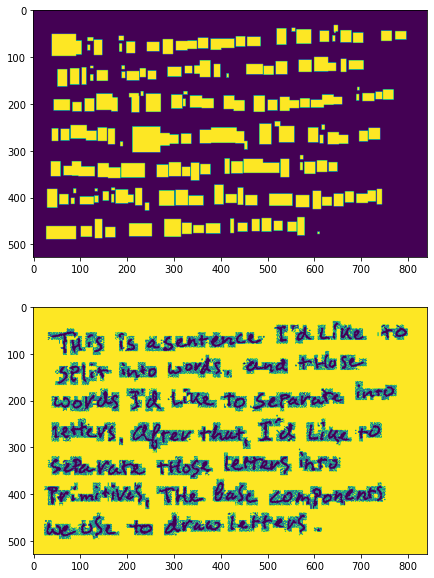

In [19]:
def getFeatureBounds(features, img, n = len(features)):
    preview = np.zeros(img.shape[:2])
    for i in range(n):
        f = features[i]
        x1 = f[2]
        y1 = f[3]
        x2 = f[4]
        y2 = f[5]
        for x in range(x1, x2):
            for y in range(y1, y2):
                preview[y][x] = 255
    return preview

print(len(features))
boxes = getFeatureBounds(features, absgray, len(features) - 1)
showImages([boxes, absgray])    

#checks if an entry exists in a list
def inList(n, arr):
    for a in arr:
        if n == a:
            return True
    return False

def inBox(p, x1, x2, y1, y2):
    if p[0] >= x1 and p[0] <= x2:
        if p[1] >= y1 and p[1] <= y2:
            return True
    return False

def over(box1, box2):
    points = []
    points.append([box1[2], box1[3]])
    points.append([box1[4], box1[3]])
    points.append([box1[2], box1[5]])
    points.append([box1[4], box1[5]])
    bx1 = box2[2]
    bx2 = box2[4]
    by1 = box2[3]
    by2 = box2[5]
    for p in points:
        if inBox(p, bx1, bx2, by1, by2):
            return True
    return False

def overlap(boxA, boxB):
    #if any of the boxes making up boxA overlap with any of the boxes in boxB they can be combined
    for a in range(len(boxA)):
        box1 = boxA[a]
        for b in range(len(boxB)):
            box2 = boxB[b]
            if over(box1, box2):
                return True
    return False

def stitchBox(boxA, boxB):
    out = []
    for a in range(len(boxA)):
        out.append(boxA[a])
    for b in range(len(boxB)):
        out.append(boxB[b])
    return out

def stitchLoop(boxes):
    #return boxes
    stitched = []
    stitchedBoxes = []
    for a in range(len(boxes)):
        boxA = boxes[a]
        for b in range(len(boxes)):
            if (a != b): #don't check self
                if (inList(b, stitched) == False):
                    boxB = boxes[b]
                    if (overlap(boxA, boxB)):
                        boxA = stitchBox(boxA, boxB)
                        stitched.append(b)
        stitchedBoxes.append(boxA)
    return stitchedBoxes

#function that stitches boxes together with overlapping bounds
def stitchBoxes(boxes, loops = 2):
    stitched = boxes
    for i in range(loops):
        stitched = stitchLoop(stitched)
    return stitched  

def showBoxes(boxes, img):
    #print(len(boxes))
    preview = np.zeros(img.shape[:2])
    for i in range(len(boxes) - 1):
        boxcollection = boxes[i]
        for b in range (len(boxcollection)):
            box = boxcollection[b]
            x1 = box[2]
            x2 = box[4]
            y1 = box[3]
            y2 = box[5]
            for x in range(x1, x2):
                for y in range(y1, y2):
                    preview[y][x] = 255
    plt.imshow(preview)
    #ax1.imshow(imgray)
    #ax2.imshow(preview)
    #plt.plot()
    
    
def getCharacters(boxes, imgray):
    chars = []
    for i in range(len(boxes) - 1):
        box = boxes[i]
        w = box[4] - box[2]
        h = box[5] - box[3]
        char = np.zeros((h, w))
        for x in range(w):
            for y in range(h):
                x1 = x + box[2]
                x2 = y + box[3]
                char[y][x] = imgray[x2][x1]
        chars.append(char)
    return chars

def getAngle(p1, p2):
    return math.atan2(p2[0] - p1[0], p2[1] - p1[1])

def findLines(boxes, maxdistance = 10000):
    winners = []
    edge = 1 / 3
    for b in boxes:
        p1 = b[:2]
        iswinner = True
        for b2 in boxes:
            if b != b2:
                p2 = b2[:2]
                if (abs(getAngle(p1, p2)) > (math.pi / 2) + edge): #there's another point in f.o.v.
                    if abs(p1[0] - p2[0]) < maxdistance: #it's within an acceptable distance above and below
                        iswinner = False
                        break #no need to keep searching
        if (iswinner): #it survived
            winners.append(b)
    return winners   

lines = findLines(features)
print(lines)
def split(points, avg):
    l = []
    h = []
    for p in points:
        if p < avg:
            l.append(p)
        else:
            h.append(p)
    lower = np.array(l)
    lower[::-1].sort()
    higher = np.array(h)
    higher.sort()
    print('n lower: ', len(lower), ' n higher: ', len(higher))
    return[lower, higher]
    
def divideInTwo(boxes, dimension):
    bnp = np.array(boxes)
    lst = np.sort(bnp[:, dimension])
    print(lst)
    count = 0
    total = 0
    smalljump = lst[len(lst) - 1] - lst[0]
    avgjump = smalljump / len(boxes)
    print('avg jump: ', avgjump)
    bigjump = 0
    pp = lst[0]
    
    #there's two sorts of jumps, one for special characters that should have been part of a line are about the size of
    #the average jump so far, or smaller
    jumps = []
    for i in range(1, len(lst)):
        jump = lst[i] - pp
        pp = lst[i]
        jumps.append(jump)
    splitjumps = split(jumps, avgjump)
    print(splitjumps)
        
    #print(ylist)
    
    #print(y_positions)
    #for b in boxes:
        
# def showCharacters(characters):
#     total = 10 #len(characters)
#     fig, axes = plt.subplots(total, 1)
#     for i in range(total):
#         axes[i].imshow(characters[i])
#     plt.plot()
    
#boxes = getContours(absgray)
#startinglines = findLines(boxes)
#print(startinglines, len(startinglines))
#divideInTwo(startinglines, 0)
#boxes = stitchBoxes(boxes, 1)

#showBoxes(boxes, imgray)
#print(combinedboxes)
#lines = getLines(boxes, imgray)
#showBoxes(boxes, imgray)
#chars = getCharacters(boxes, imgray)
#print(chars[0])
#plt.imshow(chars[3])
#print(chars)
#showCharacters(chars)

#plt.imshow(indi, ces)
#tst = np.zeros(imgray.shape[:2])


#plt.imshow(tst)


seperate the textblock into lines of text

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

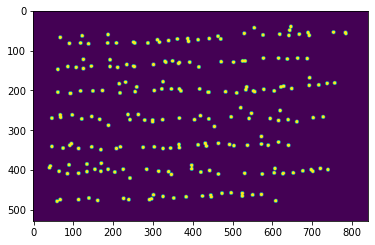

In [69]:
def sqdist(x1, y1, x2, y2):
    return np.square(x2 - x1) + np.square(y2 - y1)

def blob(canvas, x, y, r):
    h,w = canvas.shape[:2]
    x1 = x - r
    x2 = x + r
    y1 = y - r
    y2 = y + r
    if (x1 < 0):
        x1 = 0
    if (x2 > w):
        x2 = w
    if (y1 < 0):
        y1 = 0
    if (y2 > h):
        y2 = h
    for i in range(x1, x2):
        for j in range(y1, y2):
            if sqdist(x, y, i, j) < r:
                canvas[j][i] = 1

def blobbify(img, radius):
    h,w = img.shape[:2]
    blobbie = np.zeros(img.shape[:2]) #a copy reference
    rsq = np.square(radius)
    for x in range(w):
        print(x)
        for y in range(h):
            if img[y][x] > 0:
                blob(blobbie, x,y, rsq)
    return blobbie

blobbed = blobbify(indices, 5)
plt.imshow(blobbed)

#def findContours(img):
    

def dist(x1, y1, x2, y2):
    a = x2 - x1
    b = y2 - y1
    return (np.sqrt(np.square(a) + np.square(b)))
